# Cox Proportional Hazard Model

### Import Necessary and Relevant Packages

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt

### Import Data and Add the Required Time (Occurence of Event) Variable

In [2]:
#Read in data
credit_training = pd.read_csv('cs-training.csv')
credit_test = pd.read_csv('cs-test.csv')


#Create and Include observation time vector
Duration = np.ones((150000,1))*2
credit_training['Duration'] = Duration

Duration = np.ones((np.size(credit_test,0),1))*2
credit_test['Duration'] = Duration


#Drop the indexes from the data frame and the empty label from the test set
credit_training = credit_training.drop('Unnamed: 0', 1)

credit_test = credit_test.drop('Unnamed: 0', 1)
credit_test = credit_test.drop('SeriousDlqin2yrs', 1)

### Impute Missing Values

In [3]:
#Fill missing values with the median of respective features
credit_training_filled=credit_training.fillna(credit_training.median())
credit_test_filled=credit_test.fillna(credit_test.median())

#Keep data without missing value rows
credit_training_dropna=credit_training.dropna(axis=0, how='any',)

### Exploring the training data

- - - - - - - - - - -
Training set without missing value rows:


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Duration
count,120269.000000,120269.000000,120269.000000,120269.000000,120269.000000,1.202690e+05,120269.000000,120269.000000,120269.000000,120269.000000,120269.000000,120269.0
mean,0.069486,5.899873,51.289792,0.381769,26.598777,6.670221e+03,8.758475,0.211925,1.054519,0.187829,0.851832,2.0
std,0.254280,257.040685,14.426684,3.499234,424.446457,1.438467e+04,5.172835,3.465276,1.149273,3.447901,1.148391,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,0.000000,0.035084,40.000000,0.000000,0.143388,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,2.0
50%,0.000000,0.177282,51.000000,0.000000,0.296023,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,2.0
75%,0.000000,0.579428,61.000000,0.000000,0.482559,8.249000e+03,11.000000,0.000000,2.000000,0.000000,2.000000,2.0
max,1.000000,50708.000000,103.000000,98.000000,61106.500000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000,2.0


Total number of consumers: 120269
Number of features: 11
Number of consumers who survived: 111912
Number of students who defaulted: 8357
Default rate of the set: 0.069%
Training set with imputed values:


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Duration
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.0
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.418455e+03,8.452760,0.265973,1.018240,0.240387,0.737413,2.0
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.289040e+04,5.145951,4.169304,1.129771,4.155179,1.107021,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,2.0
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,2.0
75%,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,2.0
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000,2.0


Total number of consumers: 150000
Number of features: 11
Number of consumers who survived: 139974
Number of students who defaulted: 10026
Default rate of the set: 0.067%


/home/jd/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/jd/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:32: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


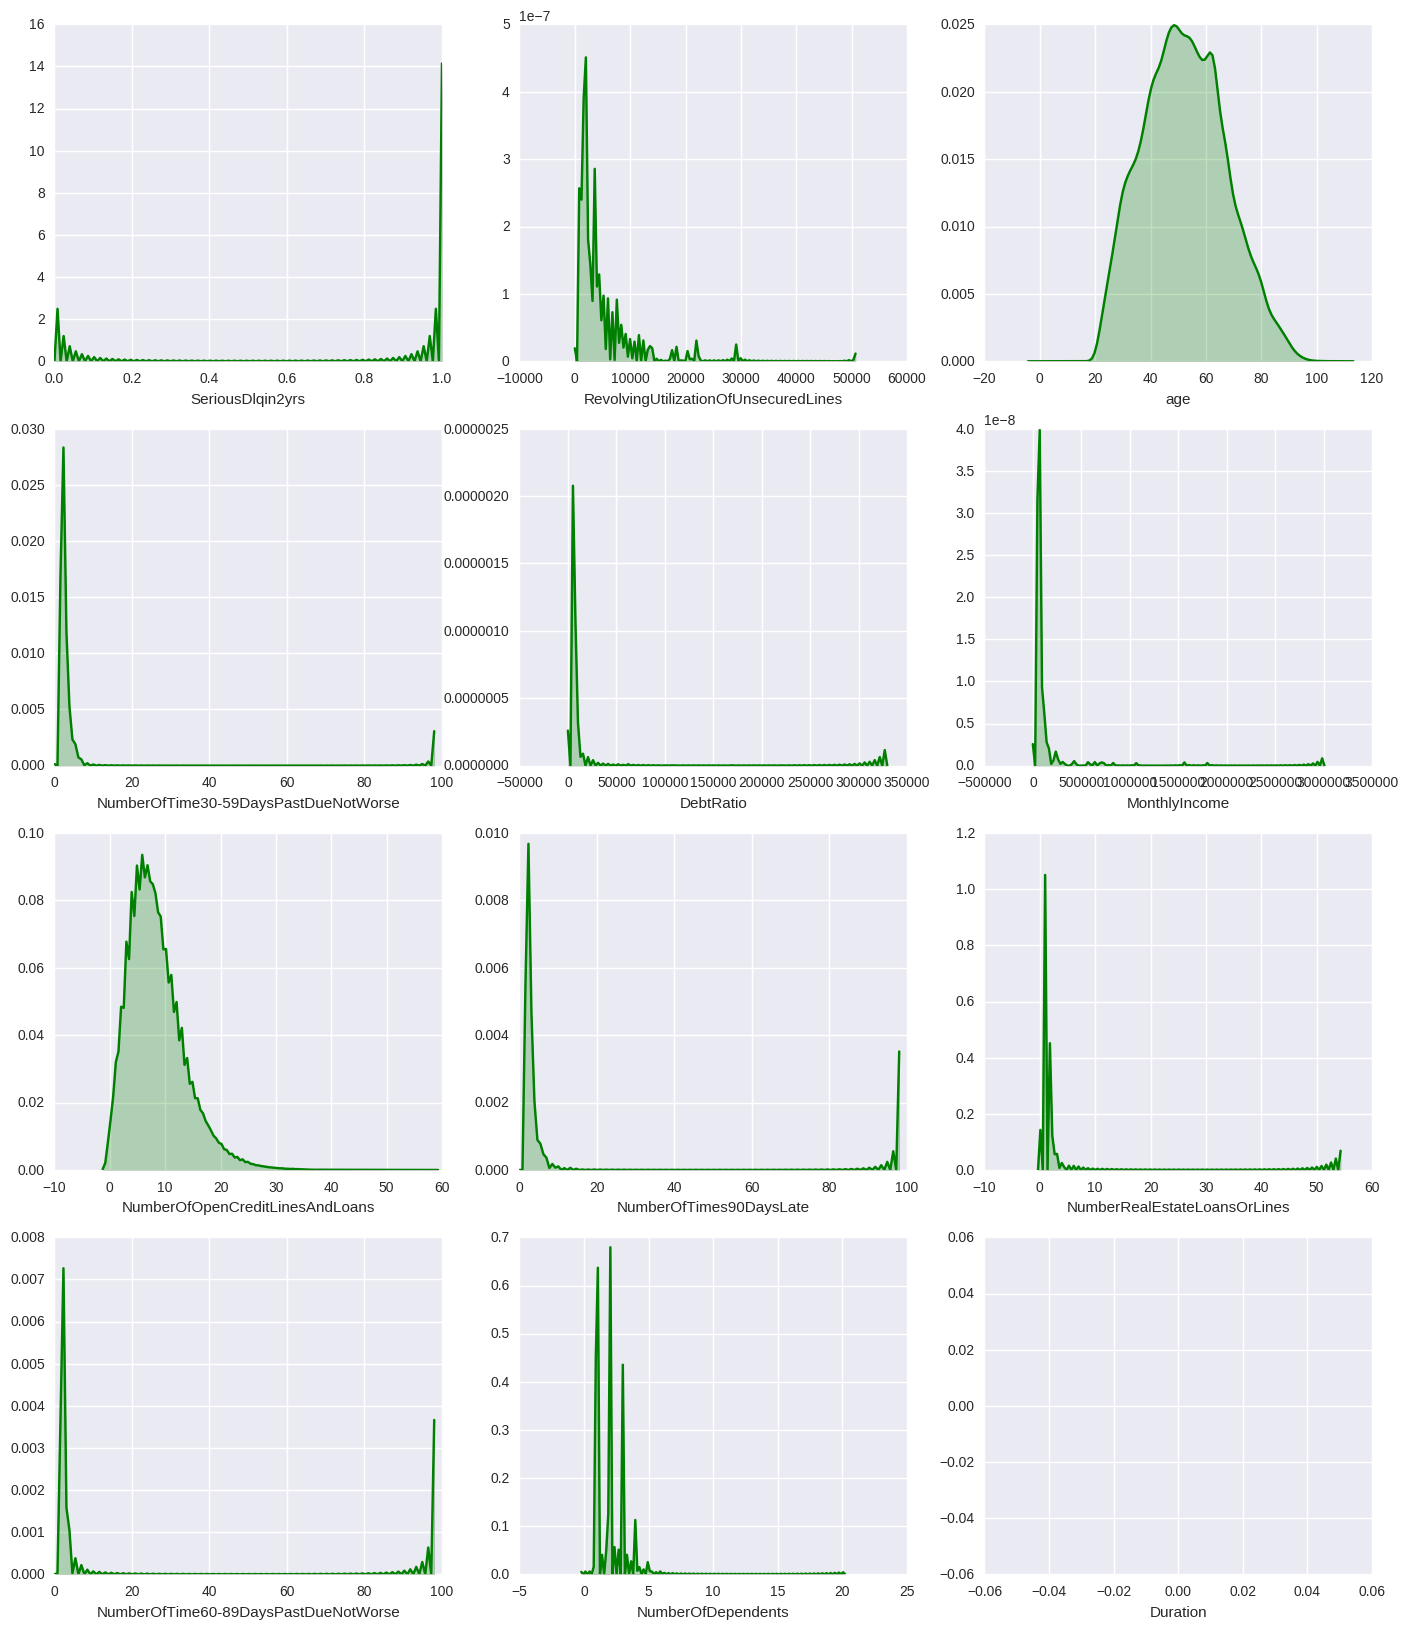

In [4]:
### Data Exploration with no imputed values ###
print '- - - - - - - - - - -'
print 'Training set without missing value rows:'
display(credit_training_dropna.describe(include='all'))

# Calculate number of consumers
n_consumers = np.size(credit_training_dropna,0) 

# Calculate number of features
n_features = np.size(credit_training_dropna,1)-1

# Calculate good standing consumers
n_survived = credit_training_dropna.SeriousDlqin2yrs.value_counts()[0]

# Calculate defaulting consumers
n_default = credit_training_dropna.SeriousDlqin2yrs.value_counts()[1]

# Calculate default rate
default_rate = 1.0*n_default/(n_survived+n_default)

# Print the results
print "Total number of consumers: {}".format(n_consumers)
print "Number of features: {}".format(n_features)
print "Number of consumers who survived: {}".format(n_survived)
print "Number of students who defaulted: {}".format(n_default)
print "Default rate of the set: {:.3f}%".format(default_rate)



### Data exploration with imputed values ###
print 'Training set with imputed values:'
display(credit_training_filled.describe(include='all'))

# Calculate number of consumers
n_consumers = np.size(credit_training_filled,0) 

# Calculate number of features
n_features = np.size(credit_training_filled,1)-1

# Calculate good standing consumers
n_survived = credit_training_filled.SeriousDlqin2yrs.value_counts()[0]

# Calculate defaulting consumers
n_default = credit_training_filled.SeriousDlqin2yrs.value_counts()[1]

# Calculate default rate
default_rate = 1.0*n_default/(n_survived+n_default)



# Print the results
print "Total number of consumers: {}".format(n_consumers)
print "Number of features: {}".format(n_features)
print "Number of consumers who survived: {}".format(n_survived)
print "Number of students who defaulted: {}".format(n_default)
print "Default rate of the set: {:.3f}%".format(default_rate)

# Plot Histograms
import seaborn as sns
fig, axs = plt.subplots(4,ncols=3, figsize=(17, 20))

i=0
k=0
cnt=0
for column in credit_training_filled:
    sns.distplot(credit_training_filled[column],hist=False, color="g", kde_kws={"shade": True},ax=axs[i,k])
    cnt=cnt+1
    i=(cnt)/3
    k=(cnt)%3

### Exploring the test data

Test set with imputed values


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Duration
count,101503.000000,101503.000000,101503.000000,101503.000000,1.015030e+05,101503.000000,101503.000000,101503.000000,101503.000000,101503.00000,101503.0
mean,5.310000,52.405436,0.453770,344.475020,6.566861e+03,8.453514,0.296691,1.013074,0.270317,0.74915,2.0
std,196.156039,14.779756,4.538487,1632.595231,3.269909e+04,5.144100,4.515859,1.110253,4.503578,1.12860,0.0
min,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,2.0
25%,0.030131,41.000000,0.000000,0.173423,3.900000e+03,5.000000,0.000000,0.000000,0.000000,0.00000,2.0
50%,0.152586,52.000000,0.000000,0.364260,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.00000,2.0
75%,0.564225,63.000000,0.000000,0.851619,7.374000e+03,11.000000,0.000000,2.000000,0.000000,1.00000,2.0
max,21821.000000,104.000000,98.000000,268326.000000,7.727000e+06,85.000000,98.000000,37.000000,98.000000,43.00000,2.0


Total number of consumers in test set: 101503
Number of features: 11


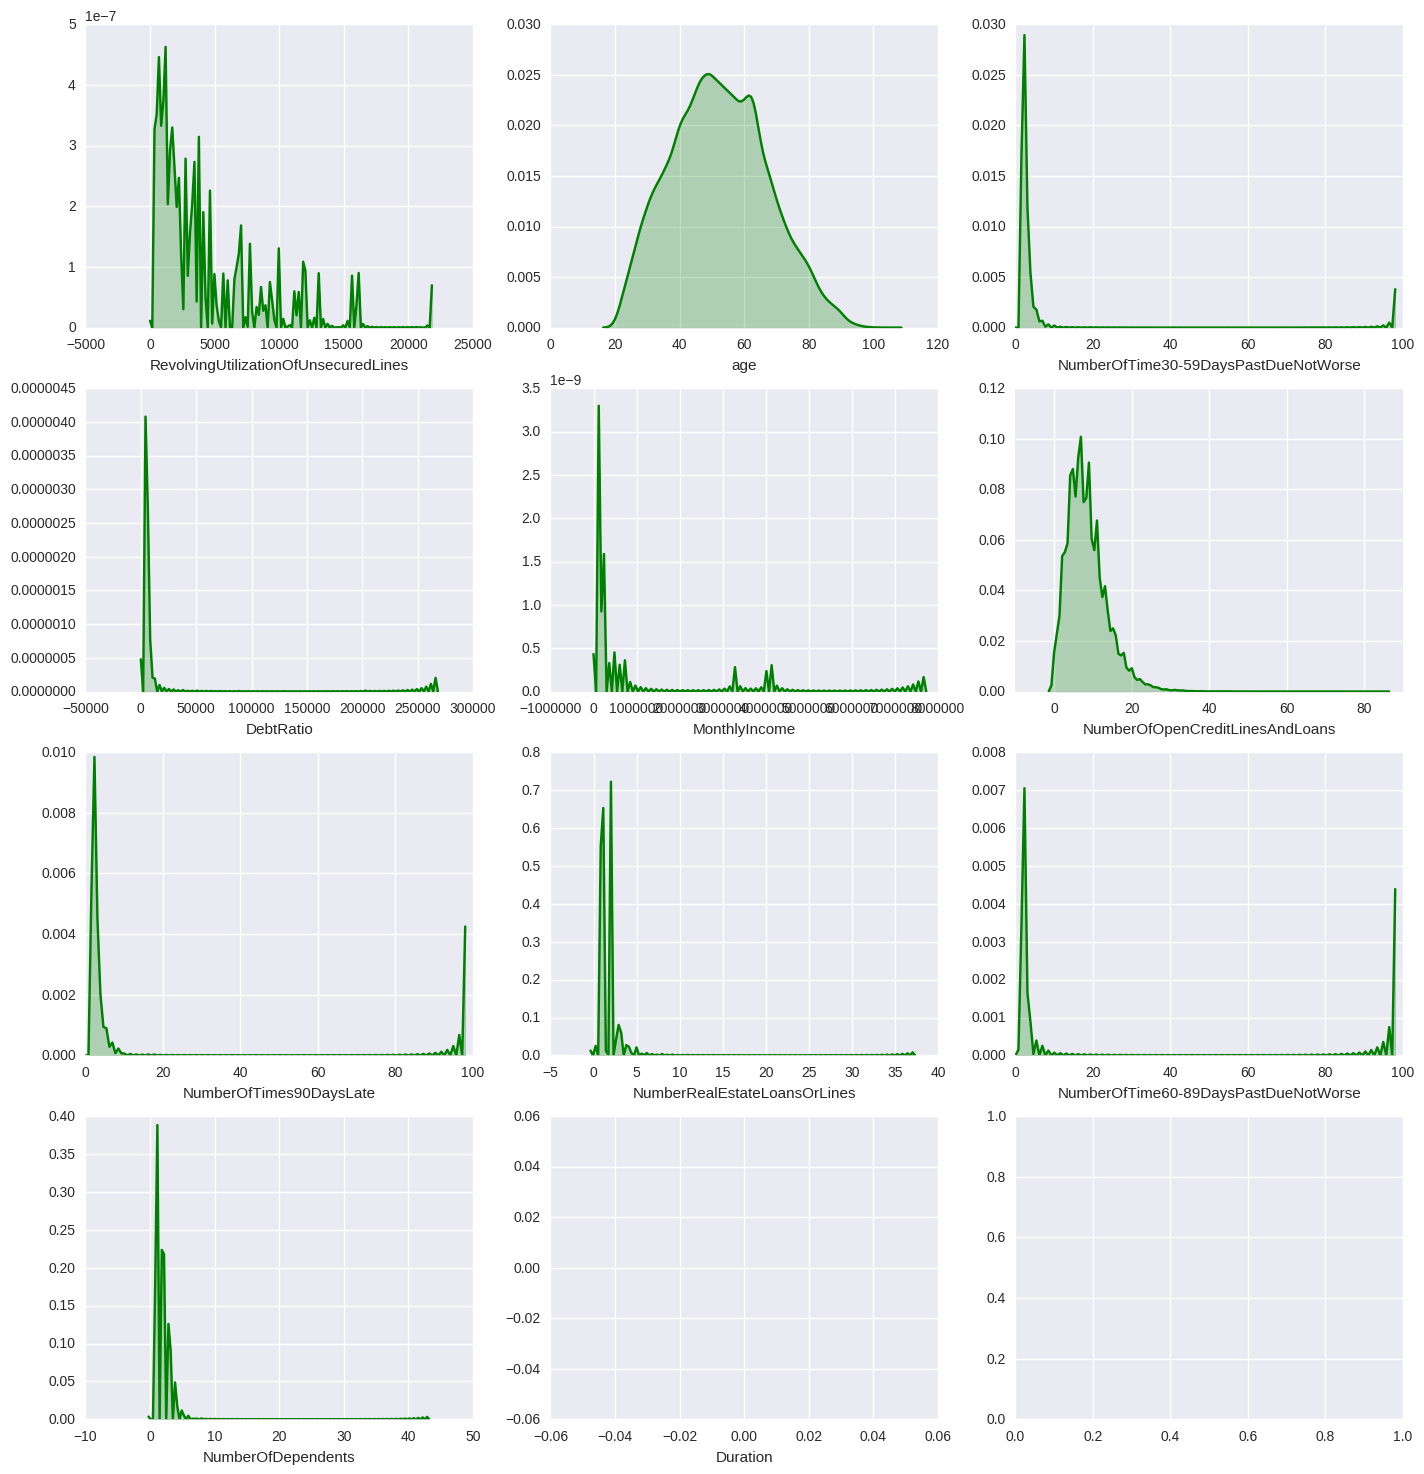

In [5]:
print 'Test set with imputed values'
display(credit_test_filled.describe(include='all'))

# Calculate number of consumers
n_consumers = np.size(credit_test,0) 

# Calculate number of features
n_features = np.size(credit_test,1)

# Print the results
print "Total number of consumers in test set: {}".format(n_consumers)
print "Number of features: {}".format(n_features)

fig, axs = plt.subplots(4,ncols=3, figsize=(17, 18))

i=0
k=0
cnt=0
for column in credit_test_filled:
    sns.distplot(credit_test_filled[column],hist=False, color="g", kde_kws={"shade": True},ax=axs[i,k])
    cnt=cnt+1
    i=(cnt)/3
    k=(cnt)%3

### Show grouped violinplots with split violins

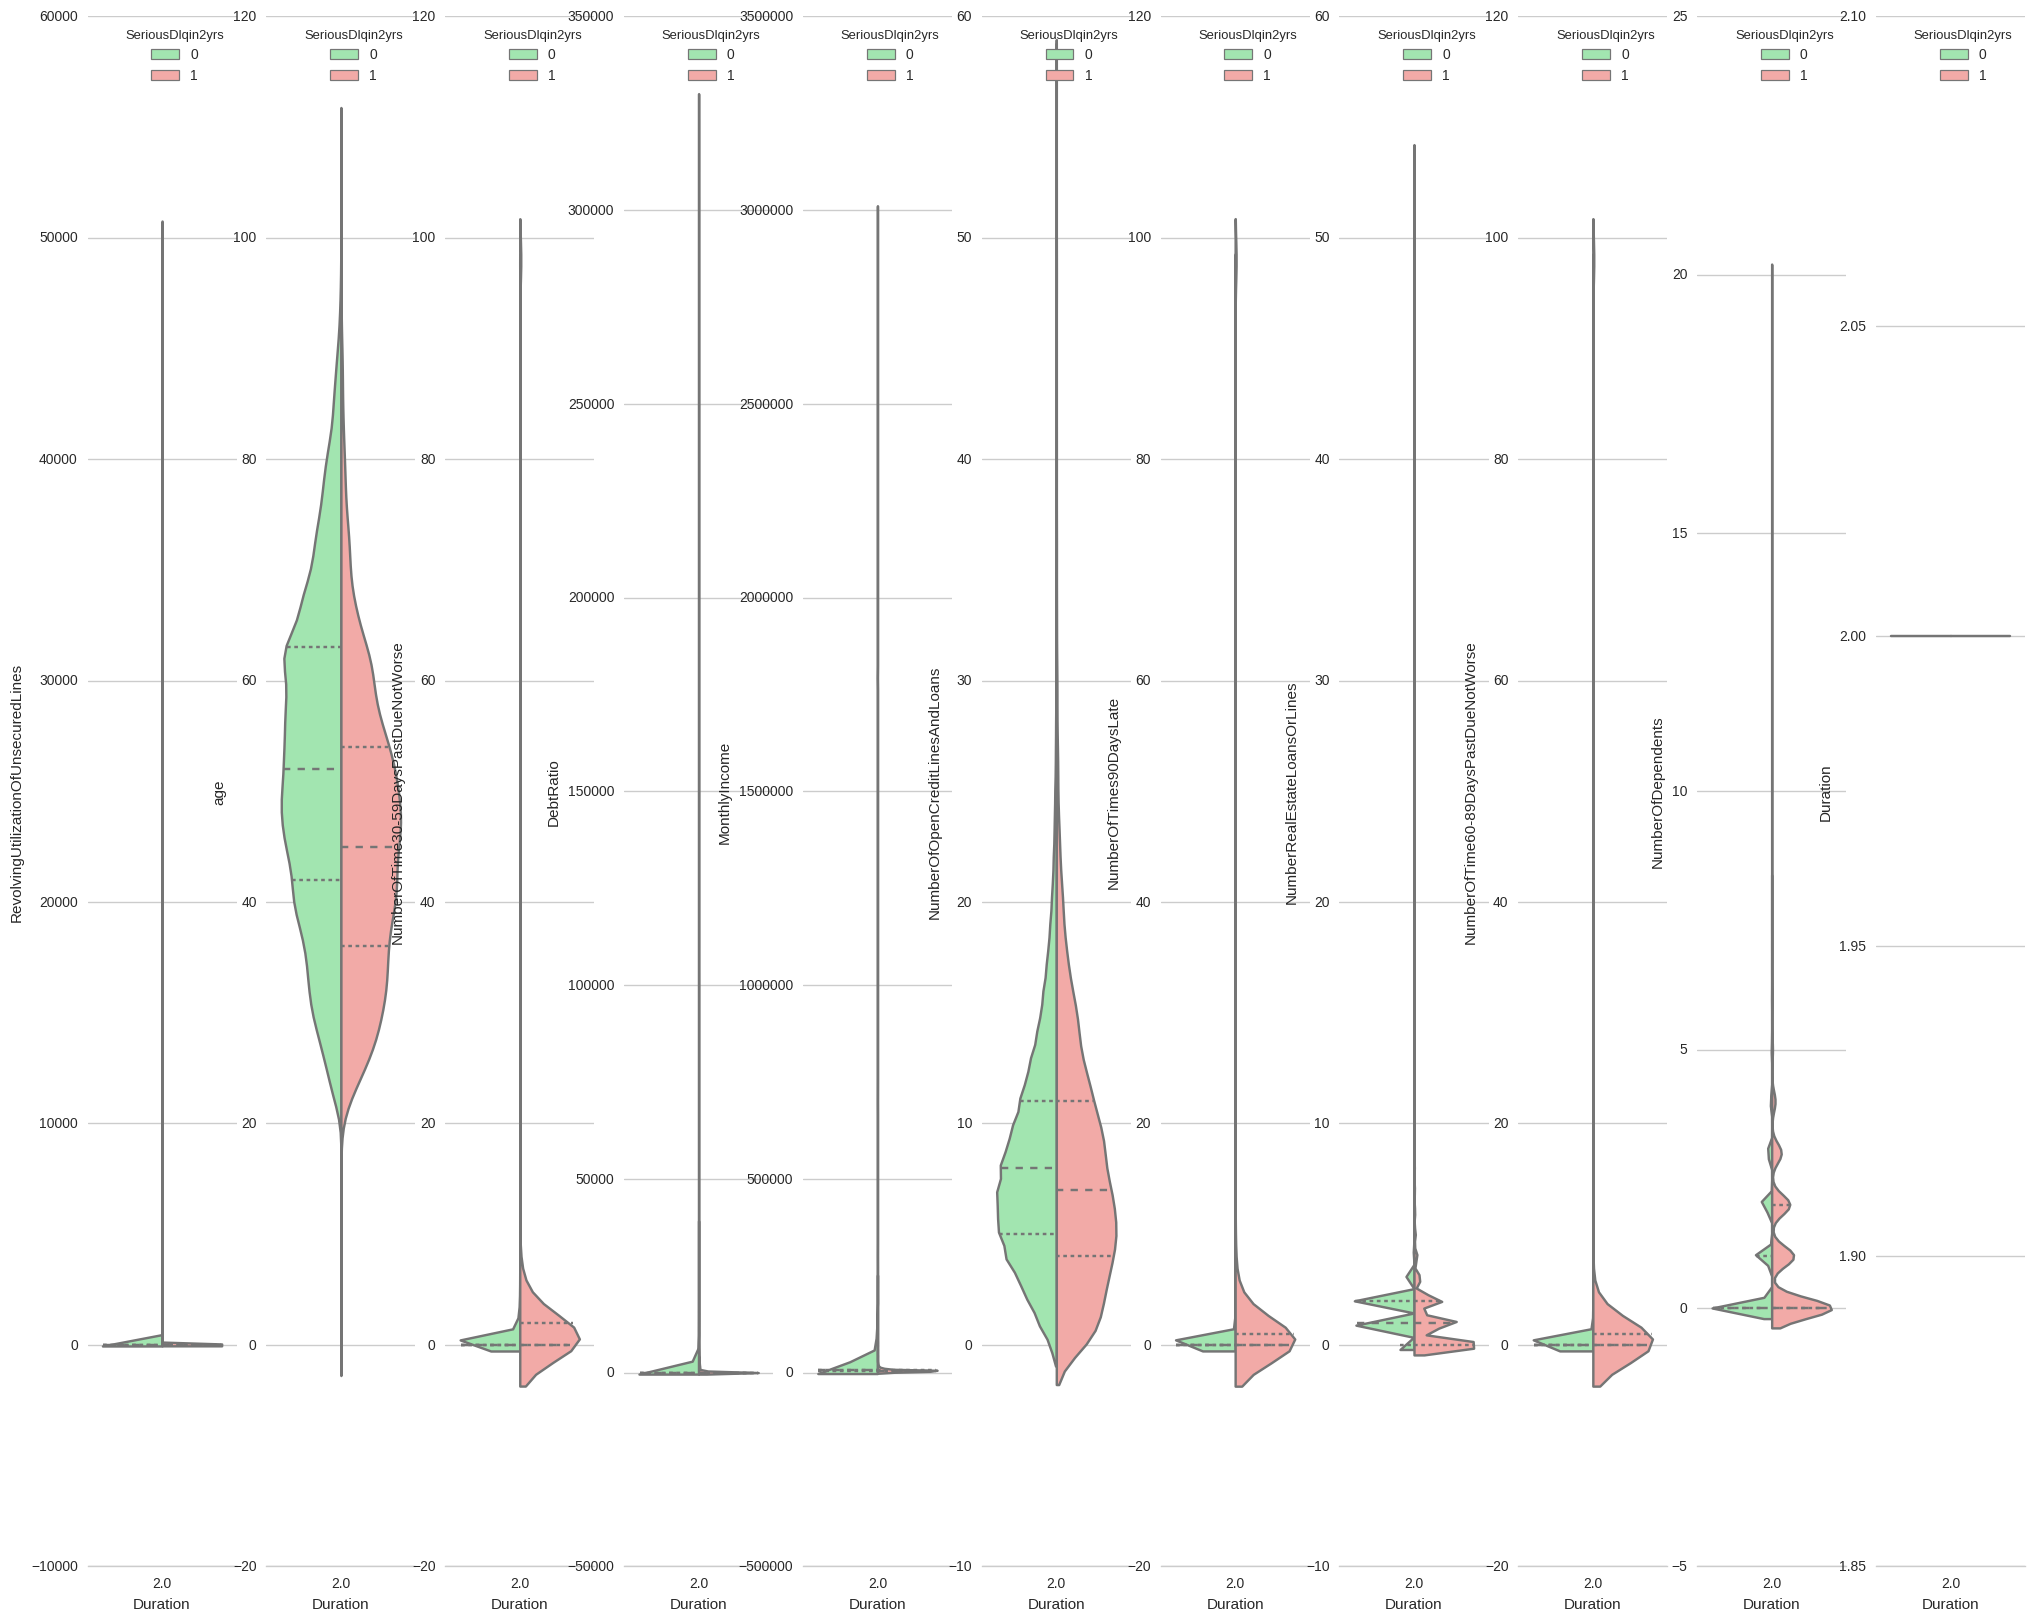

In [6]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

fig, axs = plt.subplots(1,11, figsize=(25, 20))

# Draw a nested violinplot and split the violins for easier comparison
i=0
k=0
cnt=0
for column in credit_test_filled:
    sns.violinplot(x="Duration",y=column, hue="SeriousDlqin2yrs", data=credit_training_filled, split=True,
               inner="quart",palette={0: "g", 1: "r"},scale='width',ax=axs[cnt])
    sns.despine(left=True)
    cnt=cnt+1
    i=(cnt)/2
    k=(cnt)%2

## Fit Cox Proportional Hazard

In [7]:
cf_filled = CoxPHFitter()
cf_dropna = CoxPHFitter()

#fit
cf_filled.fit(credit_training_filled, 'Duration', event_col='SeriousDlqin2yrs')
cf_dropna.fit(credit_training_dropna, 'Duration', event_col='SeriousDlqin2yrs')

#print summary
print 'FILLED Fit:'
print
cf_filled.print_summary()

print '- - - - - - - - - - - -'
print 'DROPPED NAN Fit:'
print
cf_dropna.print_summary()

FILLED Fit:

n=150000, number of events=10026

                                           coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
RevolvingUtilizationOfUnsecuredLines  4.574e-03  1.005e+00 1.068e+01  4.284e-04  9.997e-01  -2.092e+01   2.093e+01     
age                                  -3.564e-01  7.002e-01 1.408e-02 -2.531e+01 2.427e-141  -3.840e-01  -3.288e-01  ***
NumberOfTime30-59DaysPastDueNotWorse  1.456e+00  4.291e+00 3.594e+01  4.053e-02  9.677e-01  -6.899e+01   7.191e+01     
DebtRatio                            -1.209e-01  8.861e-01 1.063e+00 -1.137e-01  9.094e-01  -2.205e+00   1.963e+00     
MonthlyIncome                        -4.170e-01  6.590e-01 5.889e-02 -7.082e+00  1.420e-12  -5.325e-01  -3.016e-01  ***
NumberOfOpenCreditLinesAndLoans       4.532e-02  1.046e+00 6.107e-01  7.421e-02  9.408e-01  -1.152e+00   1.242e+00     
NumberOfTimes90DaysLate               5.792e-01  1.785e+00 5.559e+01  1.042e-02  9.917e-01  -1.084e+02   1.096e+0

### Imputation Cross-Validation Results

In [8]:
#Cross Validate with kfold
np.random.seed(seed=12345)
scoref = k_fold_cross_validation(cf_filled, credit_training_filled, 'Duration', event_col='SeriousDlqin2yrs', k=3)
np.random.seed(seed=12345)
scorena = k_fold_cross_validation(cf_dropna, credit_training_dropna, 'Duration', event_col='SeriousDlqin2yrs', k=3)

#Print Results
for scores, label in zip([scoref,scorena],['Score with filled missing values:','Score with dropped missing values:']):
    print
    print label
    print "Scores: {}".format(scores)
    print "Score Mean: {:.4f}%".format(np.mean(scores))
    print "Score StdDev: {:.4f}%".format(np.std(scores))
    print


Score with filled missing values:
Scores: [0.69899828985937096, 0.67700842762309354, 0.71104231937508577]
Score Mean: 0.6957%
Score StdDev: 0.0141%


Score with dropped missing values:
Scores: [0.68838277621679678, 0.68594777601127166, 0.6972514535337011]
Score Mean: 0.6905%
Score StdDev: 0.0049%



### Make and Store Predictions for Submission

In [9]:
#fit
cf_filled.fit(credit_training_filled, 'Duration', event_col='SeriousDlqin2yrs')
cf_dropna.fit(credit_training_dropna, 'Duration', event_col='SeriousDlqin2yrs')

#store prediction
pred=cf_filled.predict_survival_function(credit_test_filled)
pred_dropna=cf_dropna.predict_survival_function(credit_test_filled)

#Drop time zero survival which we assume to always be 1
pred=pred.drop(0.0,0)
pred_dropna=pred_dropna.drop(0.0,0)

#Save the compliment of survival to a csv for submission
s=pd.DataFrame(pred)
s=s.transpose()
s=1-s
s.to_csv('submissionCoxPH.csv')

#Save the compliment of survival to a csv for submission
sdna=pd.DataFrame(pred_dropna)
sdna=sdna.transpose()
sdna=1-sdna
sdna.to_csv('submissionCoxPHnoNA.csv')

In [10]:
print
print 'Cox PH, Filled NaN values'
Cox_filled_submission_url = 'http://i.imgur.com/VbYKJ5K.jpg'
Image(url=Cox_filled_submission_url)


Cox PH, Filled NaN values


In [11]:
print
print 'Cox PH, Removed NaN from training'
Cox_filled_submission_url = 'http://i.imgur.com/nwyMEWI.jpg'
Image(url=Cox_filled_submission_url)


Cox PH, Removed NaN from training


## Box-Cox Fit

### Box-Cox Transform Age

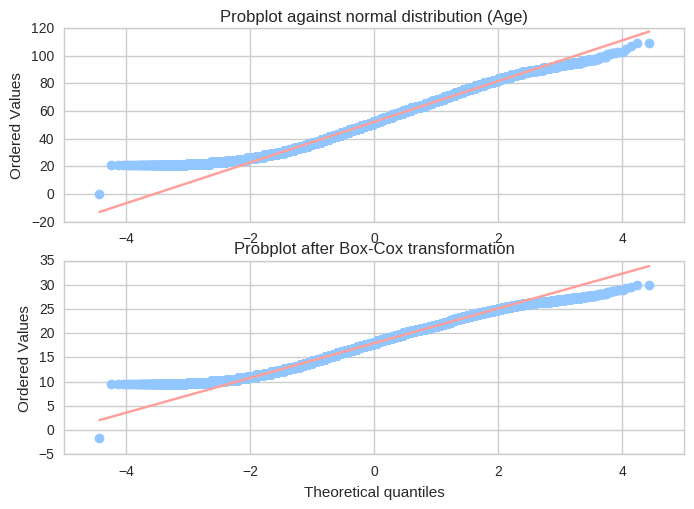

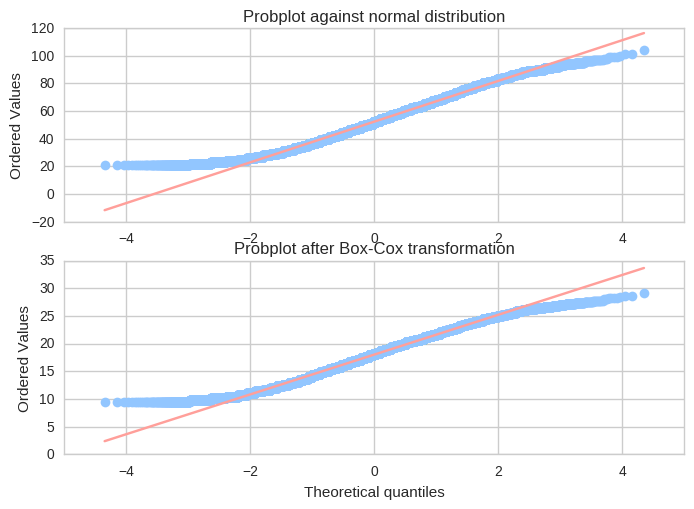

In [12]:
#import stats for Box-Cox
from scipy import stats

credit_training_filled_BC1=credit_training_filled
credit_test_filled_BC1=credit_test_filled
temp=credit_training_filled_BC1


#training
fig = plt.figure()
ax1 = fig.add_subplot(211)
x = temp['age']+.001
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution (Age)')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
credit_training_filled_BC1['age']=xt



#test
fig = plt.figure()
ax1 = fig.add_subplot(211)
x = credit_test_filled['age']+.001
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
credit_test_filled_BC1['age']=xt

#fig, axs = plt.subplots(2,ncols=1, figsize=(20, 5))
#
#sns.distplot(credit_training_filled['age'],ax=axs[0])
#sns.distplot(credit_training_filled_BC1['age'],ax=axs[1])

### Box-Cox Transform Monthly Income

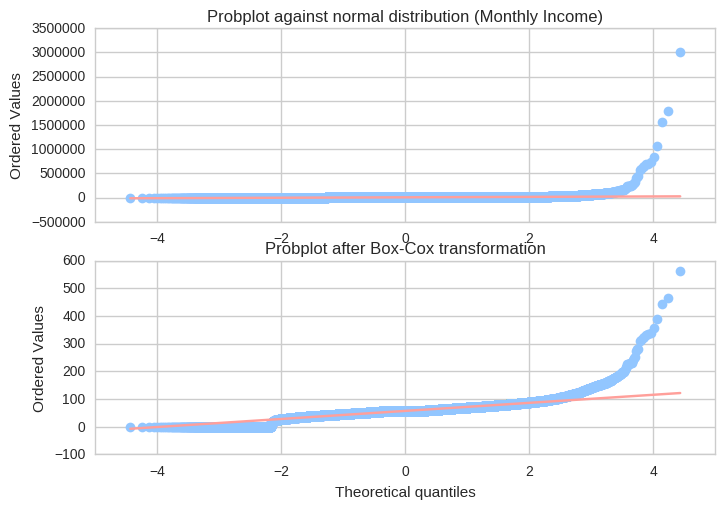

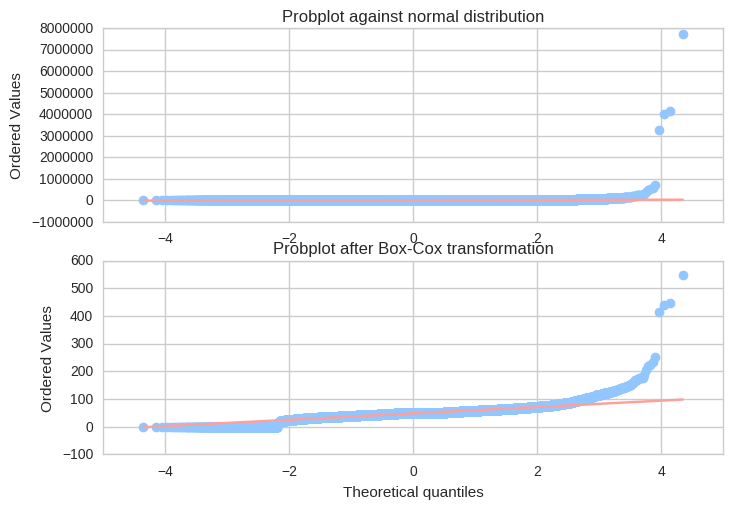

In [13]:
credit_training_filled_BC2=credit_training_filled_BC1
credit_test_filled_BC2=credit_test_filled_BC1

#training
fig = plt.figure()
ax1 = fig.add_subplot(211)
x = credit_training_filled_BC1['MonthlyIncome']+.001
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution (Monthly Income)')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
credit_training_filled_BC2['MonthlyIncome']=xt



#test
fig = plt.figure()
ax1 = fig.add_subplot(211)
x = credit_test_filled_BC1['MonthlyIncome']+.001
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
credit_test_filled_BC2['MonthlyIncome']=xt

#fig, axs = plt.subplots(2,ncols=1, figsize=(20, 5))
#
#sns.distplot(credit_training_filled['MonthlyIncome'],ax=axs[0])
#sns.distplot(credit_training_filled_BC2['MonthlyIncome'],ax=axs[1])

### Box-Cox Transform Revolving Utilization Of Unsecured Lines

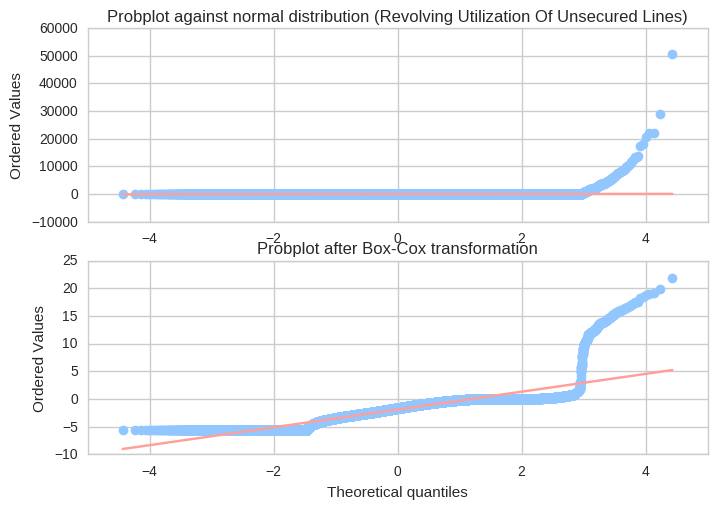

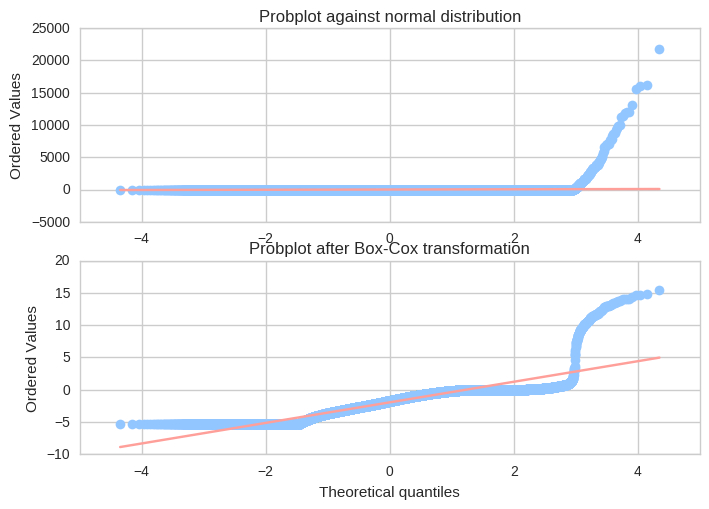

In [14]:
credit_training_filled_BC3=credit_training_filled_BC2
credit_test_filled_BC3=credit_test_filled_BC2


#training
fig = plt.figure()
ax1 = fig.add_subplot(211)
x = credit_training_filled_BC2['RevolvingUtilizationOfUnsecuredLines']+.0001
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution (Revolving Utilization Of Unsecured Lines)')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
credit_training_filled_BC3['RevolvingUtilizationOfUnsecuredLines']=xt



#test
fig = plt.figure()
ax1 = fig.add_subplot(211)
x = credit_test_filled_BC2['RevolvingUtilizationOfUnsecuredLines']+.001
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
credit_test_filled_BC3['RevolvingUtilizationOfUnsecuredLines']=xt

#fig, axs = plt.subplots(2,ncols=1, figsize=(20, 5))
#
#sns.distplot(credit_training_filled['RevolvingUtilizationOfUnsecuredLines'],ax=axs[0])
#sns.distplot(credit_training_filled_BC3['RevolvingUtilizationOfUnsecuredLines'],ax=axs[1])

### Fit

In [15]:
BC = CoxPHFitter()

#fit
BC.fit(credit_training_filled_BC3,'Duration', event_col='SeriousDlqin2yrs')

#print summary
BC.print_summary()

n=150000, number of events=10026

                                           coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
RevolvingUtilizationOfUnsecuredLines  3.642e-01  1.439e+00 5.693e-03  6.397e+01  0.000e+00   3.530e-01   3.753e-01  ***
age                                  -3.003e-01  7.406e-01 1.131e-02 -2.655e+01 2.309e-155  -3.225e-01  -2.782e-01  ***
NumberOfTime30-59DaysPastDueNotWorse  1.436e+00  4.203e+00 3.344e-02  4.294e+01  0.000e+00   1.370e+00   1.501e+00  ***
DebtRatio                            -5.606e-02  9.455e-01 1.994e-02 -2.811e+00  4.939e-03  -9.516e-02  -1.696e-02   **
MonthlyIncome                        -1.273e-01  8.805e-01 1.080e-02 -1.178e+01  4.903e-32  -1.484e-01  -1.061e-01  ***
NumberOfOpenCreditLinesAndLoans      -2.465e-03  9.975e-01 1.208e-02 -2.041e-01  8.383e-01  -2.614e-02   2.121e-02     
NumberOfTimes90DaysLate               9.980e-01  2.713e+00 3.332e-02  2.995e+01 4.118e-197   9.327e-01   1.063e+00  ***
Number

### Cross-Evaluate Results

In [16]:
#Cross Validate with kfold
np.random.seed(seed=12345)
scoref = k_fold_cross_validation(BC, credit_training_filled_BC3, 'Duration', event_col='SeriousDlqin2yrs', k=3)

#Print Results
for scores, label in zip([scoref],['Score with normalized filled missing values:']):
    print
    print label
    print "Scores: {}".format(scores)
    print "Score Mean: {:.4f}%".format(np.mean(scores))
    print "Score StdDev: {:.4f}%".format(np.std(scores))


Score with normalized filled missing values:
Scores: [0.74114678170931925, 0.75913014520085664, 0.76145543277221606]
Score Mean: 0.7539%
Score StdDev: 0.0091%


### Submission Results

In [17]:
print
print 'Cox PH, BoxCox 3 vars transform filled NaN'
Cox_filled_submission_url = 'http://i.imgur.com/IGm8Ixc.jpg'
Image(url=Cox_filled_submission_url)


Cox PH, BoxCox 3 vars transform filled NaN
